# Preformed O$_2$ and DIC Test

### Analysis Objectives:
 - #### Preformed DIC Test: Can estimates of ΔDIC derived from equilibration of atmospheric CO$_2$ at outcropping regions and accompanying thermodynamic effects explain modeled ΔDIC?
 - #### Preformed O$_2$ Test: Can centennial shifts in remineralization explain modeled ΔDIC? 

### Figure Content: 
 - **Extended Data Figure 7**: The ratio of ∆DIC attributed to changes in remineralization to modeled ∆DIC at 0–200 meters depth 
 - **Extended Data Figure 8**: The ratio of preformed ∆DIC attributed to equilibration of atmospheric CO$_2$ and thermodynamic effects (Equation 3) to modeled ∆DIC at 0–50 meters, 75–125 meters, and 150–200 meters depth
 -------------

In [1]:
import sys
import os
import importlib
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import optimize
import math

In [2]:
sys.path.insert(1, '../Functions')
import Output_Cleanup_Functions as open_files
importlib.reload(open_files)

<module 'Output_Cleanup_Functions' from '/raid/mmstoll/Code/Industrial_Era_OA_Code/../Functions/Output_Cleanup_Functions.py'>

# Preformed O$_2$ Test

**Preformed O$_2$ Test Methodology:**
 - GOAL: calculate centennial shifts in remineralization using apparent oxygen utilization and the Redfield ratio determined by Hedges et al. 2002 
 1) Calculate preformed O$_2$ in the historic and modern eras using equation outlined in Garcia and Gordon (1992)
 2) Calculate O$_2$ from remineralization (preformed O$_2$ - modeled O$_2$) in both the historic and modern eras
 3) Transform O$_2$ from remineralization into DIC using the Redfield ratio determined by Hedges et al. 2002 to understand centennial shifts in remineralization  

## Example code and functions to calculate preformed O$_2$

In [3]:
def calc_pref_O2(temp, salt):
    T0_Kelvin = 273.16

    a_0 = 2.00907
    a_1 = 3.22014
    a_2 = 4.05010
    a_3 = 4.94457
    a_4 = -2.56847*10**-1
    a_5 = 3.88767
    b_0 = -6.24523*10**-3
    b_1 = -7.37614*10**-3
    b_2 = -1.03410*10**-2
    b_3 = -8.17083*10**-3
    c_0 = -4.88682*10**-7

    TS = math.log(((T0_Kelvin + 25) - temp) / (T0_Kelvin + temp))
    O2_pref = np.exp(a_0 + TS * (a_1+TS* (a_2+TS * (a_3+TS* (a_4+TS*a_5)))) + 
                    salt* ((b_0+TS* (b_1+TS* (b_2+TS*b_3))) + salt*c_0)) #units ml/l

    O2_pref_mmol_m3 = O2_pref * 44.6596 #units mmol/m3
    
    return(O2_pref_mmol_m3)

In [4]:
def pref_O2(ds):
    temp = ds['temp'][83:,:,:,:]
    salt = ds['salt'][83:,:,:,:]
    
    O2_pref_mmol_m3 = xr.apply_ufunc(
        calc_pref_O2,  #specify function
        temp, salt, #arguments for function
        output_core_dims=[[]],  #returned data has the same dimension
        vectorize=True,  #loop over non-core dims
        dask = "parallelized",   
    )

    return(O2_pref_mmol_m3)

Calculate data (historic and modern preformed O$_2$) over whole model domain for O2_pref_hist12_mod12.nc file:

In [5]:
# mod_O2_pref = pref_O2(ds_modern)
# hist_O2_pref = pref_O2(ds_historic)

## Open model and preformed O$_2$ test files

In [6]:
O2_pref_test = xr.open_dataset('/raid/mmstoll/Data/Attribution_Analyses/O2_pref_hist12_mod12.nc')

In [7]:
file_historic_12km = '/home/mmstoll/raid/Data/CCModel_Historic_Data/usw12_avg_ctracers_vintp_ROMS.nc'
file_modern_12km = '/home/mmstoll/raid/Data/CCModel_Modern_Data/usw12_avg_ctracers_vintp.nc'

In [8]:
ds_modern, ds_historic, month_list_modern, month_list_historic = open_files.open_files_12vs12(file_modern_12km, file_historic_12km)
depth_list = open_files.depths()

In [9]:
file_historic_nutrients = '/home/mmstoll/raid/Data/CCModel_Historic_Data/usw12_avg_ntracers_vintp.nc'
file_modern_nutrients = '/home/mmstoll/raid/Data/CCModel_Modern_Data/usw12_avg_ntracers_vintp.nc'

In [10]:
ds_modern_nut, ds_historic_nut, month_list_modern, month_list_historic = open_files.open_files_12vs12(file_modern_nutrients, file_historic_nutrients)
depth_list = open_files.depths()

#### Specify start and end dates for modern and historic model simulations

In [11]:
date_index_modern_start = month_list_modern.index('December 2000')
date_index_modern_end = month_list_modern.index('November 2007')
date_index_historic_start = month_list_historic.index('December 1897')
date_index_historic_end = month_list_historic.index('November 1904')

## Transform O$_2$ into DIC using Redfield ratio determined by Hedges et al. 2002

In [12]:
hedges_ratio = 106/152.5 #Hedges et al. 2002

O2_remin_mod = O2_pref_test['mod12_O2_pref']-ds_modern_nut['O2'][83,:,:,:]
DIC_remin_mod = O2_remin_mod*(hedges_ratio)

O2_remin_hist = O2_pref_test['hist12_O2_pref'] - ds_historic_nut['O2'][83,:,:,:] 
DIC_remin_hist = O2_remin_hist*(hedges_ratio)

In [13]:
delta_remin_DIC = DIC_remin_mod[:,:,:,:]-DIC_remin_hist[:,:,:,:] #mmol/m3
delta_remin_O2 = O2_remin_mod - O2_remin_hist

## Figures

### Extended Data Figure 7

The ratio of ∆DIC attributed to changes in remineralization to modeled ∆DIC at 0–200 meters depth in the nearshore region that overlaps with the coral locations. Centennial shifts in remineralization are calculated using apparent oxygen utilization and the Redfield ratio determined by Hedges et al. 2002 (Methods). Centennial changes in remineralization can account for 15% of modeled ∆DIC at 0-200 meters depth but this process is insufficient to explain most of the observed centennial acidification.

Changes in remineralization can account for only 14% of centennial ∆DIC in the California Current.


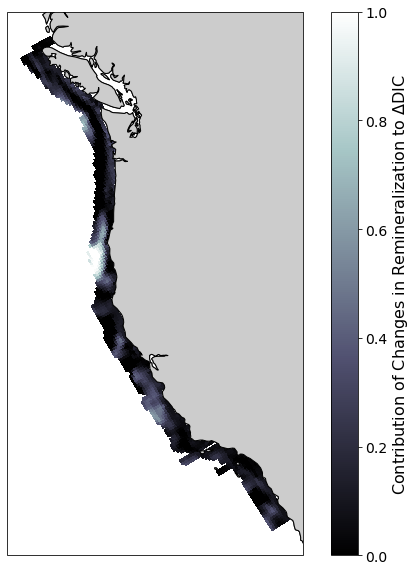

In [14]:
start_depth = 0
end_depth = 9

delta_remin = delta_remin_DIC[:,start_depth:end_depth,140:350,:].mean(dim=('time','depth'))

mod = ds_modern['DIC'][date_index_modern_start:date_index_modern_end+1,start_depth:end_depth,
                               140:350,:].mean(dim=('time','depth'))

hist = ds_historic['DIC'][date_index_historic_start:date_index_historic_end+1,start_depth:end_depth,
                                  140:350,:].mean(dim=('time','depth'))
diff = mod - hist

cmin = 0
cmax = 1

fig = plt.figure(figsize = (10,10))
proj = ccrs.LambertConformal(central_longitude = -127, central_latitude = 37)
ax = fig.add_subplot(111, projection = proj)
coastal_xarray = []
cmap = matplotlib.cm.get_cmap('bone')

plot_ds = delta_remin/diff

for row in plot_ds['eta_rho'][0:-1]:
    indices_list = np.argwhere(np.isnan(np.array(delta_remin[row])))
    x_index = int(indices_list[0])
    coastal_xarray.append(plot_ds[int(row), x_index-8:x_index].values.astype(float))
    xarray = plot_ds[int(row):int(row+2), x_index-8:x_index]

    if int(row) == int(plot_ds['eta_rho'][-2]):
        x_plot = xarray.plot(transform = ccrs.PlateCarree(),cmap=cmap,x = 'lon_rho', y = 'lat_rho',
                    vmin = cmin, vmax = cmax, add_colorbar=False)   
        cbar = plt.colorbar(x_plot)
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('Contribution of Changes in Remineralization to $\Delta$DIC', size = 16)

    else:
        xarray.plot(transform = ccrs.PlateCarree(),cmap=cmap,x = 'lon_rho', y = 'lat_rho',
                    vmin = cmin, vmax = cmax, add_colorbar=False)   

coast_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='0.8')
ax.add_feature(coast_50m)
ax.add_feature(coast_50m)
np.mean(coastal_xarray)
print('Changes in remineralization can account for only '+str(round(np.mean(coastal_xarray)*100))+'% of centennial ∆DIC in the California Current.')

# Preformed DIC Test

**Preformed DIC Test Methodology:**
 - GOAL: Determine whether estimates of ΔDIC derived from equilibration of atmospheric CO$_2$ at outcropping regions and accompanying thermodynamic effects explain  modeled ΔDIC
 1) Calculate preformed historic DIC (from historic TA and $p$CO$_2$ of historic atmosphere)
    - 1900: 295 $\mu$atm; carbon content independent of water mass age because atmospheric CO$_2$ relatively stable in pre-industrial era
 2) Calculate preformed modern DIC (from historic TA and $p$CO$_2$ of atmosphere depending on water mass age)
    - 1980: 339 $\mu$atm
    - 1993: 357 $\mu$atm
    - 2000-2007 average: 376 $\mu$atm
 3) Calculate $\Delta$DIC between the preformed historic and preformed modern values
 4) Add $\Delta$DIC from step 3 to the modeled historic DIC value to yield an estimate of modern DIC 
 5) Compare the estimated modern DIC value (derived from preformed DIC) to the modeled modern DIC value
 - If the difference between the estimated and actual modern values is small, this implies that the ocean's uptake of atmospheric CO$_2$ can explain much of the centennial increase in $p$CO$_2$
 - Preformed DIC tests run for 0, 13, and 25 year water mass ages

## Example code and functions to calculate preformed DIC

In [15]:
def calc_pref_values(temp, sal, Alk, pCO2):
    DIC_pref = calc_DIC(temp, sal, Alk, pCO2)
    return(DIC_pref)

In [16]:
def calc_delta_pref_DIC():
    hist_rho = ds_historic['rho'][83:,:,:,:]+1027.4
    hist_temp = ds_historic['temp'][83:,:,:,:]
    hist_sal = ds_historic['salt'][83:,:,:,:]
    hist_Alk = ds_historic['Alk'][83:,:,:,:]/(hist_rho*1000) #mol/kg
    hist_pCO2 = 295 #atmospheric CO2 1900

    mod_rho = ds_modern['rho'][83:,:,:,:]+1027.4
    mod_temp = ds_modern['temp'][83:,:,:,:]
    mod_sal = ds_modern['salt'][83:,:,:,:]
    mod_Alk = ds_modern['Alk'][83:,:,:,:]/(mod_rho*1000) #mol/lkg
    mod_pCO2 = 376 #atmospheric CO2 avg 2000-2007
        
    hist_pref_DIC = xr.apply_ufunc(
        calc_pref_values,  #specify function
        hist_temp, hist_sal, hist_Alk, hist_pCO2, # arguments for function
        output_core_dims=[[]],  # returned data has the same dimension
        vectorize=True,  # loop over non-core dims
        dask = "parallelized",   
    )
    
    mod_pref_DIC = xr.apply_ufunc(
        calc_pref_values,  # first the function
        mod_temp, mod_sal, mod_Alk, mod_pCO2, # arguments for function
        output_core_dims=[[]],  # returned data has the same dimension
        vectorize=True,  # loop over non-core dims
        dask = "parallelized",   
    )
    
    
    return(hist_pref_DIC, mod_pref_DIC)

Create data for DIC_pref_0yrs.nc file:

In [17]:
# hist_pref_DIC_0yrs, mod_pref_DIC_0yrs = calc_delta_pref_DIC()

## Open preformed DIC test files

In [18]:
DIC_pref_0yrs = xr.open_dataset('/raid/mmstoll/Data/Attribution_Analyses/DIC_pref_0yrs.nc')
DIC_pref_13yrs = xr.open_dataset('/raid/mmstoll/Data/Attribution_Analyses/DIC_pref_13yrs.nc')
DIC_pref_25yrs = xr.open_dataset('/raid/mmstoll/Data/Attribution_Analyses/DIC_pref_25yrs.nc')

## Figures

In [19]:
title_size = 16
axis_size = 14
marker_size = 10
cap_size = 4
tick_size = 12
legend_size = 14

In [20]:
def is_jja(month, month_start, month_end):
        return (month >= month_start) & (month <= month_end)

### Extended Data Figure 8

The ratio of ∆DIC preformed attributed to equilibration of atmospheric CO$_2$ and thermodynamic effects (Equation 3) to modeled ∆DIC at 0–50 meters, 75–125 meters, and 150–200 meters depth (∆DICpreformed/∆DICmodeled, Methods).

 - Water Mass Age = 0 years (0-50 m)
   - age = '0yrs'
   - start_depth = 0 (0 m)
   - end_depth = 3 (75 m)
 - Water Mass Age = 13 years (75-125 m)
   - age = '13yrs'
   - start_depth = 3 (75 m)
   - end_depth = 6 (150 m)
 - Water Mass Age = 25 years (150-200 m)
   - age = '25yrs'
   - start_depth = 6 (150 m)
   - end_depth = 9 (200 m)

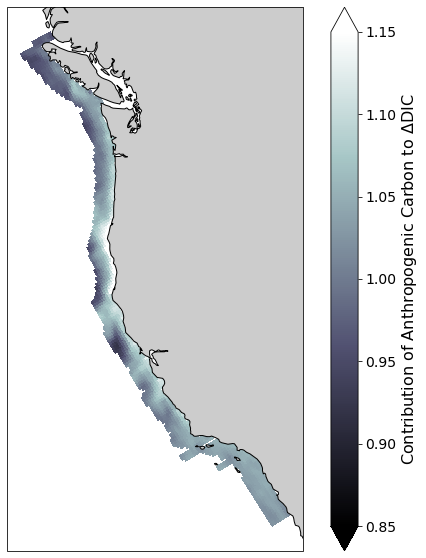

In [21]:
#Input age and depth indices given above inputs
age = '0yrs'
start_depth = 0
end_depth = 3
parameter = 'DIC'

if age == '0yrs':
    ds = DIC_pref_0yrs
if age == '13yrs':
    ds = DIC_pref_13yrs
if age == '25yrs':
    ds = DIC_pref_25yrs

fig = plt.figure(figsize = (10,10))
proj = ccrs.LambertConformal(central_longitude = -127, central_latitude = 37)
ax = fig.add_subplot(111, projection = proj)
cmap = matplotlib.cm.get_cmap('bone')

coastal_xarray = []

mod = ds_modern[parameter][date_index_modern_start:date_index_modern_end+1, start_depth:end_depth,
                               140:350,0:].mean(dim=('time','depth'))

hist = ds_historic[parameter][date_index_historic_start:date_index_historic_end+1, start_depth:end_depth,
                                  140:350,0:].mean(dim=('time','depth'))

diff = mod - hist
diff_pref = ds['delta_pref_DIC'][:,start_depth:end_depth, 140:350, 0:].mean(dim=('time','depth'))

cmin = 0.85 
cmax = 1.15

plot_ds = diff_pref/diff

for row in plot_ds['eta_rho'][0:-1]:
    indices_list = np.argwhere(np.isnan(np.array(plot_ds[row])))
    x_index = int(indices_list[0])
    coastal_xarray.append(plot_ds[int(row), x_index-8:x_index].values.astype(float))
    xarray = plot_ds[int(row):int(row+2), x_index-8:x_index]

    if int(row) == int(plot_ds['eta_rho'][-2]):
        x_plot = xarray.plot(transform = ccrs.PlateCarree(),cmap = cmap,
                             x = 'lon_rho', y = 'lat_rho', vmin = cmin, vmax = cmax,
                             add_colorbar=False) 
        cbar = plt.colorbar(x_plot, extend = 'both')
        cbar.ax.tick_params(labelsize=14)
        cbar.set_label('Contribution of Anthropogenic Carbon to $\Delta$DIC', size = 16)
        
    else:
        xarray.plot(transform = ccrs.PlateCarree(),cmap=cmap,x = 'lon_rho', y = 'lat_rho',
                    vmin = cmin, vmax = cmax, add_colorbar=False)   

coast_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='k', facecolor='0.8')
ax.add_feature(coast_50m)